# <center>Курсовой проект<center>

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import chi2_contingency, boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from collections import Counter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

C:\Users\GruXsqK\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\GruXsqK\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def get_clear_data(df_in):
    
    DEL_LIST = ['Tax Liens',
                'Maximum Open Credit',
                'Number of Credit Problems',
                'Months since last delinquent',
                'Bankruptcies' ,
                'Years in current job']
    
    DF = df_in.copy()
    
    DF.loc[(DF['Credit Score'] > 999), 'Credit Score'] = DF.loc[(DF['Credit Score'] > 999), 'Credit Score']/10
    DF.loc[DF['Annual Income']> 5000000, 'Annual Income'] = float('NaN')
    
    
    DF.loc[(DF['Current Loan Amount']==99999999), 'Current Loan Amount'] = \
        np.absolute(DF.loc[(DF['Current Loan Amount']==99999999), 'Maximum Open Credit'] - \
        DF.loc[(DF['Current Loan Amount']==99999999), 'Current Credit Balance'])
    
    MAIN_PURPOSE = ['debt consolidation', 'home improvements', 'business', 'other']
    SECONDARY_PURPOSE = np.setdiff1d(DF['Purpose'].unique(), MAIN_PURPOSE)
    
    DF.replace(['business loan', 'small business', 'renewable energy', 'educational expenses'], 'business', inplace=True)
    DF.replace(['buy house', 'buy a car', 'medical bills', 'major purchase'], 'home improvements', inplace=True)
    DF.replace(SECONDARY_PURPOSE, 'other', inplace=True)
    
    DF.drop(DEL_LIST, axis=1, inplace=True)
    
    return DF

In [3]:
def add_parameters(DF, lmbda_for_income):
    
    DF['Monthly Credit Burden'] = DF['Monthly Debt'] * 12 / inv_boxcox(DF['Annual Income'], lmbda_for_income)

    DF['Residual Loan Share'] = DF['Current Loan Amount'] / (DF['Current Loan Amount'] + DF['Current Credit Balance'])
    DF['Residual Loan Share'].fillna(0, inplace=True)
    
    return DF

In [4]:
def plot_r2_forest(X_train, y_train, X_valid, y_valid, name_param, param_data):
    
    r2_on_valid = []
    r2_on_train = []

    for itm in param_data:
        
        if name_param == 'n_estimators':
            clf = RFR(n_estimators=itm, random_state=42, n_jobs=-1)
        elif name_param == 'max_features':
            clf = RFR(max_features=itm, random_state=42, n_jobs=-1)
        elif name_param == 'max_depth':
            clf = RFR(max_depth=itm, random_state=42, n_jobs=-1)
        elif name_param == 'min_samples_leaf':
            clf = RFR(min_samples_leaf=itm, random_state=42, n_jobs=-1)
        else:
            clf = RFR(random_state=itm, n_jobs=-1)
        
        clf.fit(X_train, y_train)

        r2_on_valid.append(r2_score(y_valid, clf.predict(X_valid)))
        r2_on_train.append(r2_score(y_train, clf.predict(X_train)))
        
    plt.figure(figsize = (8, 6))
    plt.plot(param_data, r2_on_valid, label="valid")
    plt.plot(param_data, r2_on_train, label="train")

    plt.xlabel(f"Значение параметра '{name_param}'")
    plt.ylabel('R2_score')

    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_over_under_sampling_binary(df, target_name):
     
    major_class, minor_class = df[target_name].value_counts().index
    
    major_quantity = df[target_name].value_counts()[major_class]
    minor_quantity = df[target_name].value_counts()[minor_class]
    
    coef_major, coef_minor = 1, 1
    
    while (minor_quantity * coef_minor) / (major_quantity * coef_major) < 0.9:
        
        coef_major -= 0.05
        coef_minor += 0.05
        
    df_major = df[df[target_name] == major_class].sample(frac=round(coef_major, 2), replace=True)
    df_minor = df[df[target_name] == minor_class].sample(frac=round(coef_minor, 2), replace=True)
    
    return pd.concat([df_major, df_minor], axis=0, ignore_index=True)

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [10]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [11]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [12]:
TARGET = 'Credit Default'
numeric_features = df_train.select_dtypes('number').columns.drop(TARGET)
categorical_features = df_train.select_dtypes('object').columns

# Обзор датасета

In [13]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Обработка выбросов и пропусков

__Посмотрим на разброс значений каждого параметра.__

__Все изменения будут описываться по порядку, но будут добавлены в одну общую функцию.__

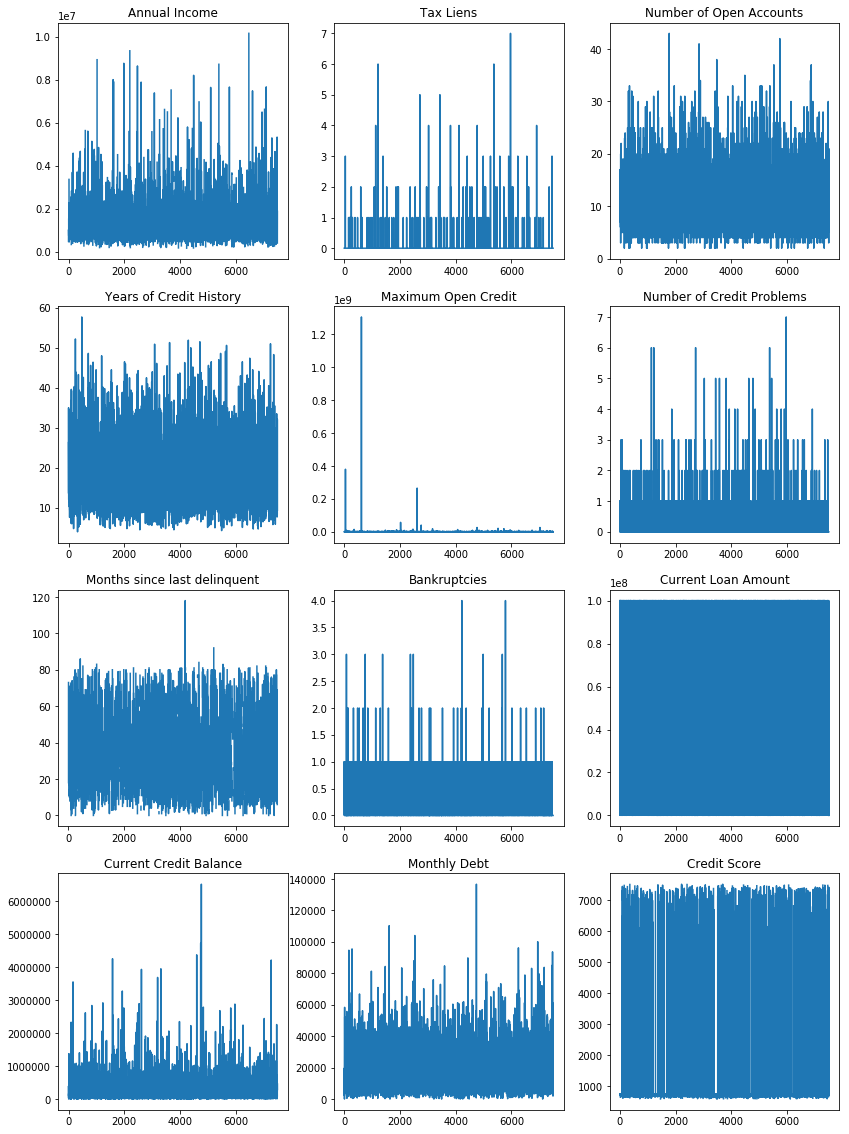

In [15]:
colmns = df_train.select_dtypes(exclude='object').columns
fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_size_inches(14, 20, forward=True)

for ax_i, colmn in zip(ax.flatten(), colmns):
    ax_i.plot(df_train[colmn])
    ax_i.set_title(colmn)
    
plt.show()

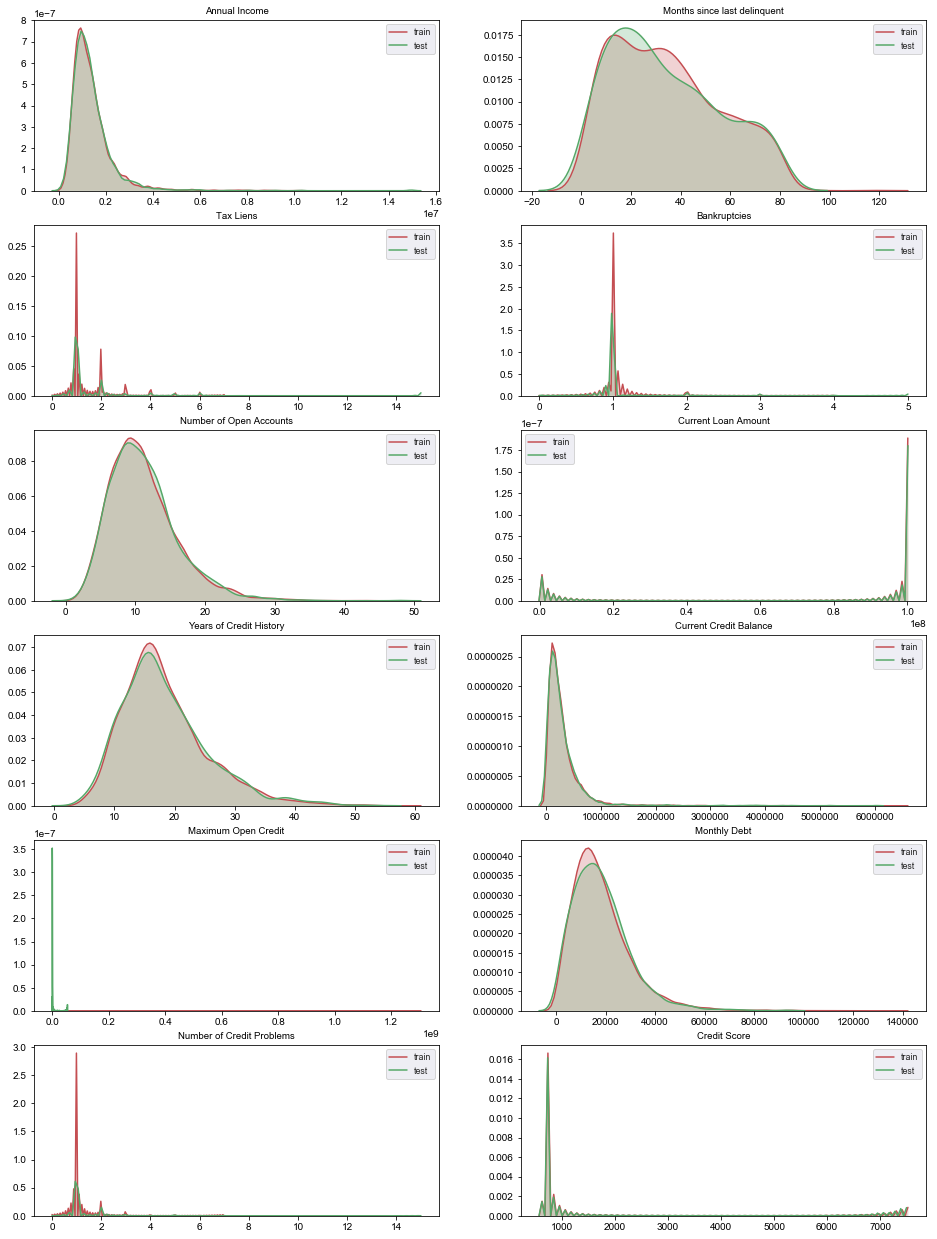

In [16]:
N_ROWS, N_COLS = 6, 2

fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(16, 22, forward=True)

for i, col in enumerate(numeric_features):
    sns.set(font_scale=0.8)
    sns.kdeplot((df_train[col]), shade=True, label='train', color='r', ax=ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)])
    sns.kdeplot((df_test[col]), shade=True, label='test', color='g', ax=ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)])
    ax[i % max(N_ROWS, N_COLS), i // max(N_ROWS, N_COLS)].set_title(col)
    
plt.show()

__Так как распределения некотрых признаков в test и train не соответствуют, то удалим эти признаки: 'Tax Liens','Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies' , 'Years in current job'.__

__Во многих параметрах присутствуют выбросы, проанализируем каждый по отдельности.__

Количество выбросов Credit Score (> 999): 400 ( 5.33 %)


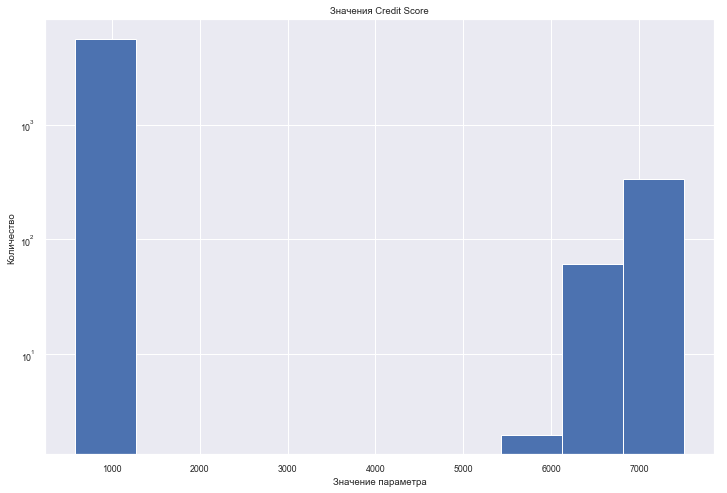

In [17]:
print('Количество выбросов Credit Score (> 999):', df_train.loc[df_train['Credit Score'] > 999].shape[0],
      '(', round(100*df_train.loc[df_train['Credit Score'] > 999].shape[0]/df_train['Credit Score'].shape[0], 2), '%)')

plt.figure(figsize = (12, 8))
plt.hist(df_train['Credit Score'], bins=10, log=True, label=['Credit Score'])
plt.title('Значения Credit Score')
plt.xlabel('Значение параметра')
plt.ylabel('Количество')
plt.show();

In [18]:
df_train['Credit Score'].loc[df_train['Credit Score'] > 999].head(8)

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
152    7140.0
153    7470.0
198    7370.0
Name: Credit Score, dtype: float64

__На графике видно, что значения кредитного рейтинга имеют выбросы, которые на порядок отличаются от других. Исходя из того, что данных выбросов менее 6%, выбросы кратны 10 и по данным банков России данный рейтинг принимает значения от 1 до 999; сократим выбросы на один порядок.__

Медианное значение Credit Score: 729.0


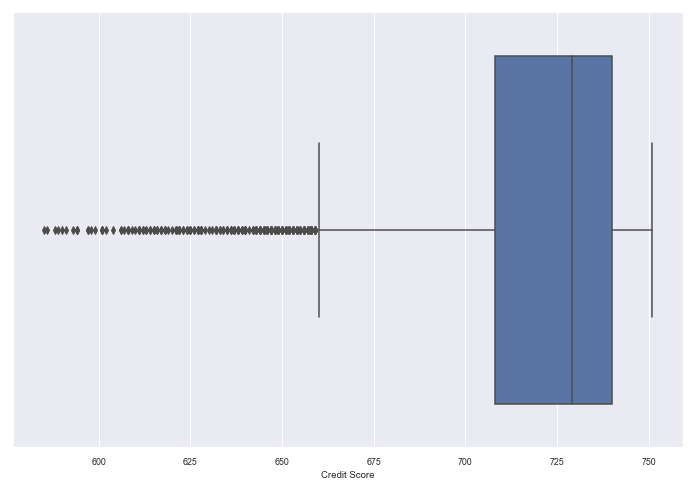

In [19]:
df_train.loc[(df_train['Credit Score'] > 999), 'Credit Score'] = \
    df_train.loc[(df_train['Credit Score'] > 999), 'Credit Score']/10
    
credit_score_data = df_train.loc[(df_train['Credit Score'].notnull()), 'Credit Score']
plt.figure(figsize = (12, 8))
sns.boxplot(credit_score_data)

print('Медианное значение Credit Score:', credit_score_data.median())

In [20]:
df_train.loc[(df_train['Current Loan Amount']==99999999)].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


__В датасете присутствуют наблюдения с выбросами "Current Loan Amount", которые равны 99999999. Приравняем их к модулю разности "Maximum Open Credit" и "Current Credit Balance". Таким образом мы допускаем, что текущий кредит является наибольшим и текущая сумма кредита равна разности максимального кредита и текущего баланса кредита.__

__Рассмотрим категориальные переменные.__

In [21]:
for cat_colname in df_train.select_dtypes(include=['object']).columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
**************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
************************

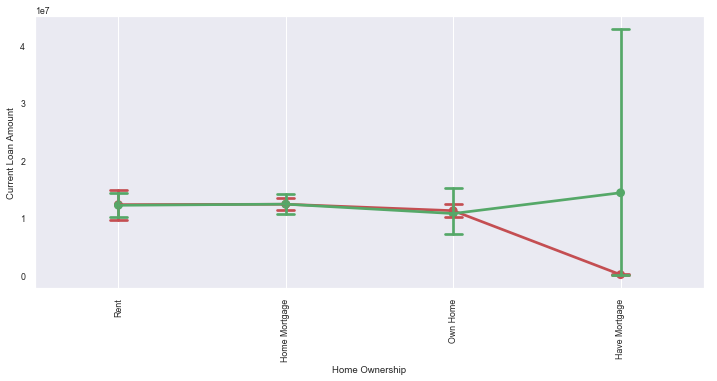

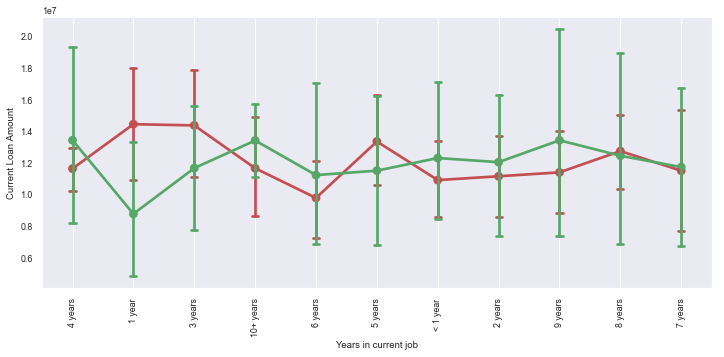

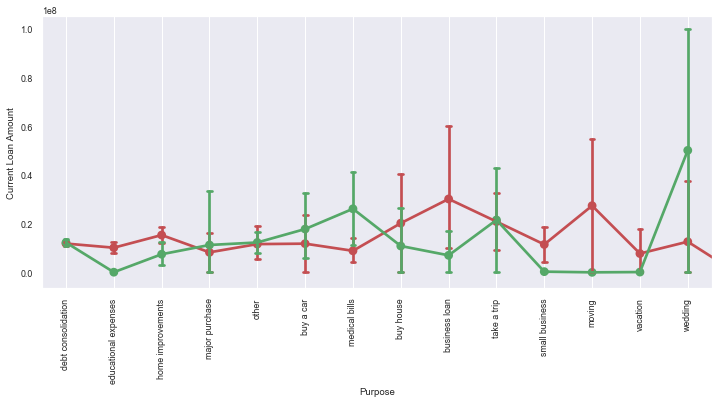

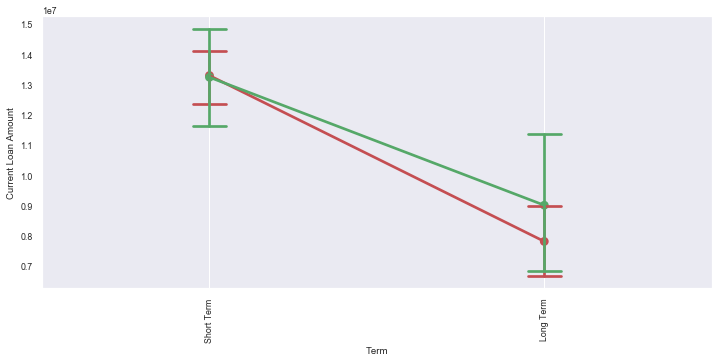

In [22]:
for col in df_train.select_dtypes('object').columns:
    plt.figure(figsize=(12, 5))
    sns.pointplot(x=col, y='Current Loan Amount', data=df_train, capsize=.1, color='r')
    sns.pointplot(x=col, y='Current Loan Amount', data=df_test, capsize=.1, color='g')
    plt.xticks(rotation='vertical')
    plt.grid()
    plt.show()

**Наблюдение**

__Изучив получившиеся данные, видно, что многие значения признака Purpose имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет объединить их в одну общую категорию.__

**Гипотеза** 

* __Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы__
* __Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы__
* __Критерий: Хи-квадрат Пирсона__
* __Уровень значимости $\normalsize \alpha$: 0.05__
* __Критическая область: двухсторонняя__

__Для проверки данной гипотезы необходимо подать наблюдаемые частоты значений признака Purpose в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.__

__*Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона*__

In [23]:
all_purpose = df_train['Purpose'].unique()
main_purpose = ['debt consolidation', 'home improvements', 'business loan']
secondary_purpose = np.setdiff1d(all_purpose, main_purpose)

df = df_train.copy()
purpose_and_targets = df.loc[df['Purpose'].isin(secondary_purpose), ['ID', 'Purpose', 'Credit Default']]
purpose_and_targets['ID'] = df.index[:len(purpose_and_targets['ID'])]

table = purpose_and_targets.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count', fill_value=0)
chi2, p, dof, expected = chi2_contingency(table, correction=False)
print('p-value =', p)
table

p-value = 0.10475408532631993


Credit Default,0,1
Purpose,,
buy a car,72,24
buy house,25,9
educational expenses,9,1
major purchase,31,9
medical bills,49,22
moving,9,2
other,468,197
renewable energy,0,2
small business,12,14


__P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории: other, buy a car, medical bills, major purchase, take a trip, buy house, small business, wedding, moving, educational expenses, vacation и renewable energy одинаково влияют на целевую переменную и их можно объединить в одну категорию (other).__

__Применим все вышеуказанные изменения к датасетам__

In [24]:
df_train_clean = get_clear_data(df_train)
df_test_clean = get_clear_data(df_test)

# Анализ данных

__Построим корреляционную матрицу признаков.__

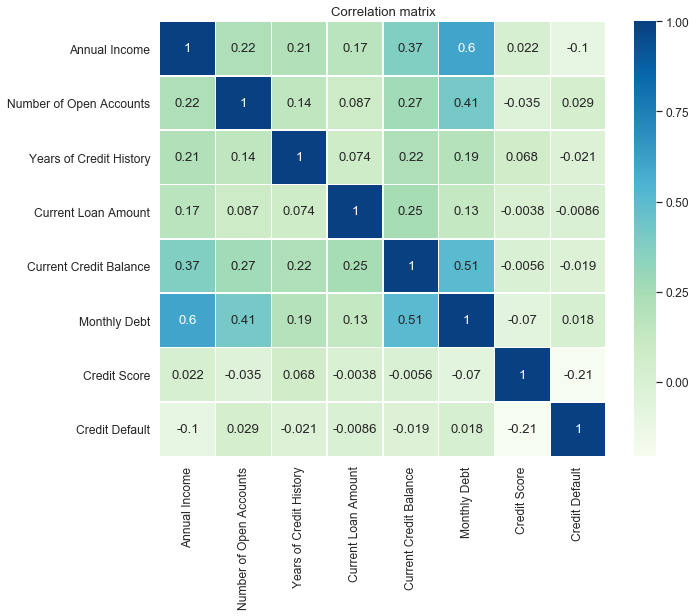

In [25]:
plt.figure(figsize = (10, 8))

sns.set(font_scale=1.1)
sns.heatmap(df_train_clean.corr().round(4), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

__Т.к. большинство признаков не коорелируют с другими, то дополнительные преобразования данных не нужны. Так же видно, что 'Annual Income' и 'Credit Score' слабо коррелируют только с несколькими признаками, значит вычислить пропущенные значения можно с помощью линейной регрессии.__

__Преобразуем колонки 'Home Ownership', 'Purpose', 'Term' и 'Years in current job' в дамми-переменные.__

In [26]:
df_train_clean = pd.get_dummies(df_train_clean, columns=['Home Ownership', 'Purpose', 'Term'])
df_test_clean = pd.get_dummies(df_test_clean, columns=['Home Ownership', 'Purpose', 'Term'])

__Разобьем датасет на X, Y. Разобьем на тренировочный и тестовый наборы данным и обучим несколько моделей, используя встроенную нормализацию этих моделей.__

In [27]:
X_income = df_train_clean[df_train_clean['Annual Income'].notnull()].drop(['Credit Score',
                                                                           'Credit Default',
                                                                           'Annual Income'], axis=1).copy()

Y_income = df_train_clean[df_train_clean['Annual Income'].notnull()]['Annual Income'].copy()

In [28]:
Y_income_boxcox, lmbda_income = boxcox(Y_income)

In [29]:
X_train_income, X_test_income, Y_train_income, Y_test_income = train_test_split(X_income, Y_income_boxcox, test_size=0.25)

In [30]:
lr_income = LinearRegression(normalize=True, n_jobs=-1).fit(X_train_income, Y_train_income)
lasso_income = Lasso(normalize=True, random_state=21).fit(X_train_income, Y_train_income)
ridge_income = Ridge(normalize=True, random_state=21).fit(X_train_income, Y_train_income)
rfr_income = RFR(random_state=21, n_estimators=1000, n_jobs=-1).fit(X_train_income, Y_train_income)

In [31]:
Y_pred_income_lr = lr_income.predict(X_test_income)
Y_pred_income_lasso = lasso_income.predict(X_test_income)
Y_pred_income_ridge = ridge_income.predict(X_test_income)
Y_pred_income_rfr = rfr_income.predict(X_test_income)

In [32]:
print('LinearRegression:', r2_score(Y_test_income, Y_pred_income_lr))
print('Lasso:', r2_score(Y_test_income, Y_pred_income_lasso))
print('Ridge:', r2_score(Y_test_income, Y_pred_income_ridge))
print('RandomForestRegressor:', r2_score(Y_test_income, Y_pred_income_rfr))

LinearRegression: 0.42270021770780486
Lasso: -0.00020491270862899036
Ridge: 0.3416561180824348
RandomForestRegressor: 0.4671883498941407


In [33]:
for model in (lr_income, lasso_income, ridge_income):

    print(f"{model}\n\n{'w0':35}{model.intercept_}")

    for itm in zip(X_income.columns, model.coef_):
        print(f"{itm[0]:35}{itm[1]}")
          
    print('\n', '#'*60, '\n')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

w0                                 19.098261474603238
Number of Open Accounts            -0.006748658253920876
Years of Credit History            0.010450916233444395
Current Loan Amount                9.606079028088775e-08
Current Credit Balance             2.1615989283799283e-07
Monthly Debt                       4.566901668271554e-05
Home Ownership_Have Mortgage       -0.2324199801430436
Home Ownership_Home Mortgage       0.1677773863945102
Home Ownership_Own Home            -0.2417252437005126
Home Ownership_Rent                -0.09486651171910497
Purpose_business                   0.21972829674657046
Purpose_debt consolidation         -0.0973660261120795
Purpose_home improvements          0.08406571556935978
Purpose_other                      0.04881755889028208
Term_Long Term                     0.06239769557789573
Term_Short Term                    -0.06239769557789573

 ##############################

__Самый лучший показатель коэффициента детерминации показывает RandomForestRegressor. Подберем ему лучшие гиперпараметры для снижения переобучения.__

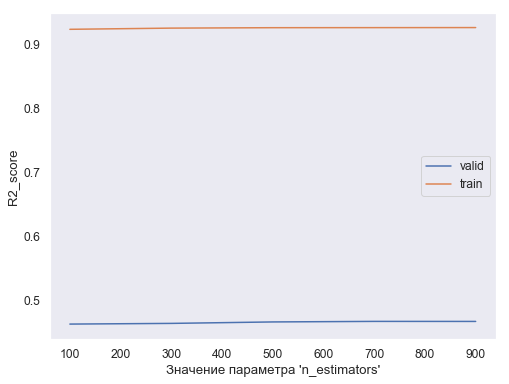

In [34]:
plot_r2_forest(X_train_income, Y_train_income, X_test_income, Y_test_income, 'n_estimators', np.arange(100, 1001, 200))

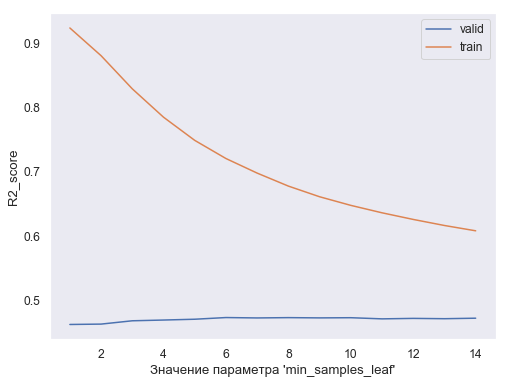

In [35]:
plot_r2_forest(X_train_income, Y_train_income, X_test_income, Y_test_income, 'min_samples_leaf', np.arange(1, 15))

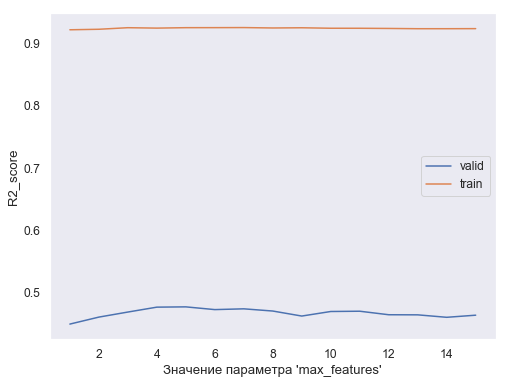

In [36]:
plot_r2_forest(X_train_income, Y_train_income, X_test_income, Y_test_income, 'max_features', np.arange(1, 16))

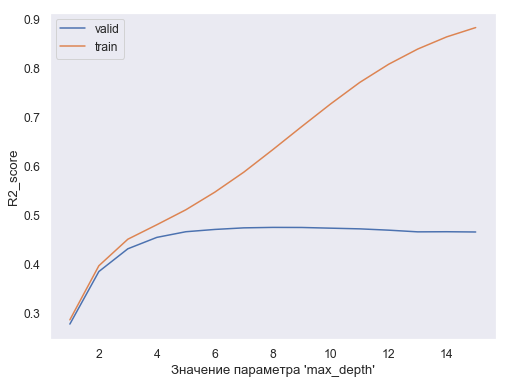

In [37]:
plot_r2_forest(X_train_income, Y_train_income, X_test_income, Y_test_income, 'max_depth', np.arange(1, 16))

In [38]:
papameters = [{'n_estimators': [1000],
               'min_samples_leaf': np.arange(6, 10),
               'max_features': np.arange(5, 7),
               'max_depth': np.arange(4, 8)}]

clf = GridSearchCV(estimator=RFR(random_state=42, n_jobs=-1), param_grid=papameters, scoring='r2')
clf.fit(X_train_income, Y_train_income)

clf.best_params_

{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 6,
 'n_estimators': 1000}

In [39]:
rfr_income_best = RFR(n_estimators=1000,
                      max_features=6,
                      min_samples_leaf=6,
                      max_depth=7,
                      n_jobs=-1,
                      random_state=21).fit(X_train_income, Y_train_income)

Y_pred_income_best = rfr_income_best.predict(X_test_income)

print('RandomForestRegressor_best:', r2_score(Y_test_income, Y_pred_income_best))

RandomForestRegressor_best: 0.48171371859642753


__Обучим модель с лучшими параметрами на всем массиве данных.__

In [40]:
X_income_empty = df_train_clean[df_train_clean['Annual Income'].isnull()].drop(['Annual Income',
                                                                                'Credit Default',
                                                                                'Credit Score'], axis=1).copy()

rfr_income_final = RFR(n_estimators=500,
                       max_features=6,
                       min_samples_leaf=6,
                       max_depth=7,
                       n_jobs=-1,
                       random_state=21).fit(X_income, boxcox(Y_income, lmbda_income))

Y_pred_income_final = rfr_income_final.predict(X_income_empty)

In [41]:
df_train_full = df_train_clean.copy()

df_train_full.loc[df_train_full['Annual Income'].notnull(), 'Annual Income'] = \
    boxcox(df_train_full.loc[df_train_full['Annual Income'].notnull(), 'Annual Income'], lmbda_income)

df_train_full.loc[df_train_full['Annual Income'].isnull(), 'Annual Income'] = Y_pred_income_final

__Обучим модель и предскажем 'Credit Score' тк же, как и 'Annual Income', используя параметры лучшей модели для 'Annual Income'.__

In [42]:
X_score = df_train_full[df_train_full['Credit Score'].notnull()].drop(['Credit Score', 'Credit Default'], axis=1).copy()

Y_score = df_train_full[df_train_full['Credit Score'].notnull()]['Credit Score'].copy()

In [43]:
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.25)

In [44]:
lr_score = LinearRegression(normalize=True, n_jobs=-1).fit(X_train_score, Y_train_score)
lasso_score = Lasso(normalize=True, random_state=21).fit(X_train_score, Y_train_score)
ridge_score = Ridge(normalize=True, random_state=21).fit(X_train_score, Y_train_score)
rfr_score = RFR(random_state=21, n_estimators=1000, n_jobs=-1).fit(X_train_score, Y_train_score)

In [45]:
Y_pred_score_lr = lr_score.predict(X_test_score)
Y_pred_score_lasso = lasso_score.predict(X_test_score)
Y_pred_score_ridge = ridge_score.predict(X_test_score)
Y_pred_score_rfr = rfr_score.predict(X_test_score)

In [46]:
print('LinearRegression:', r2_score(Y_test_score, Y_pred_score_lr))
print('Lasso:', r2_score(Y_test_score, Y_pred_score_lasso))
print('Ridge:', r2_score(Y_test_score, Y_pred_score_ridge))
print('RandomForestRegressor:', r2_score(Y_test_score, Y_pred_score_rfr))

LinearRegression: 0.2708615049278965
Lasso: -0.003011542137635548
Ridge: 0.23267004544595804
RandomForestRegressor: 0.2641451514410087


In [47]:
rfr_score_best = RFR(n_estimators=1000,
                      max_features=6,
                      min_samples_leaf=6,
                      max_depth=7,
                      n_jobs=-1,
                      random_state=21).fit(X_train_score, Y_train_score)

Y_pred_score_best = rfr_score_best.predict(X_test_score)

print('RandomForestRegressor_best:', r2_score(Y_test_score, Y_pred_score_best))

RandomForestRegressor_best: 0.2877802440461744


__Обучим данную модель на полном наборе данных и расчитаем значения пропусков 'Credit Score'.__

In [48]:
X_score_empty = df_train_full[df_train_full['Credit Score'].isnull()].drop(['Credit Score', 'Credit Default'], axis=1).copy()

rfr_score_final = RFR(n_estimators=500,
                      max_features=13,
                      min_samples_leaf=11,
                      max_depth=7,
                      n_jobs=-1,
                      random_state=21).fit(X_score, Y_score)

Y_pred_score_final = rfr_score_final.predict(X_score_empty)

In [49]:
df_train_full.loc[df_train_full['Credit Score'].isnull(), 'Credit Score'] = Y_pred_score_final

__Сохраним модели.__

In [50]:
with open('model_income.ml', 'wb') as f:
    pickle.dump(rfr_income_final, f)
    
with open('model_score.ml', 'wb') as f:
    pickle.dump(rfr_score_final, f)

__Введем дополнительные переменнуые 'Monthly Credit Burden' и 'Residual Loan Share'.__

In [51]:
df_train_full = add_parameters(df_train_full, lmbda_income)

# __Балансировка классов__

In [52]:
df_train_full['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [53]:
df_train_overfull = balance_df_over_under_sampling_binary(df_train_full, 'Credit Default')

In [54]:
df_train_overfull['Credit Default'].value_counts()

0    3232
1    2958
Name: Credit Default, dtype: int64

# Построение и оценка базовых моделей

In [55]:
Y_credit = df_train_overfull['Credit Default'].copy()
X_credit = df_train_overfull.drop('Credit Default', axis=1).copy()

X_credit_train, X_credit_test, Y_credit_train, Y_credit_test = \
    train_test_split(X_credit, Y_credit, shuffle=True, test_size=0.25, random_state=21)

In [56]:
scaler_credit = MinMaxScaler()
X_credit_train_scaled = pd.DataFrame(scaler_credit.fit_transform(X_credit_train), columns=X_credit_train.columns)
X_credit_test_scaled = pd.DataFrame(scaler_credit.transform(X_credit_test), columns=X_credit_test.columns)

__Создадим список индексов категориальных столбцов.__

In [57]:
cat_features_lst = []

cat_columns = X_credit.select_dtypes(include='uint8').columns

for idx, column in enumerate(X_credit.columns):
    if column in cat_columns:
        cat_features_lst.append(idx)
        
X_credit_train_scaled[cat_columns] = X_credit_train_scaled[cat_columns].astype('int32', copy=False)
X_credit_test_scaled[cat_columns] = X_credit_test_scaled[cat_columns].astype('int32', copy=False)

**Логистическая регрессия**

In [58]:
model_lr = LogisticRegression(random_state = 21, n_jobs=-1)
model_lr.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_lr.predict(X_credit_train_scaled)
Y_test_pred = model_lr.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      2407
           1       0.64      0.54      0.59      2235

    accuracy                           0.63      4642
   macro avg       0.64      0.63      0.63      4642
weighted avg       0.64      0.63      0.63      4642

TEST

              precision    recall  f1-score   support

           0       0.64      0.71      0.68       825
           1       0.62      0.54      0.58       723

    accuracy                           0.63      1548
   macro avg       0.63      0.63      0.63      1548
weighted avg       0.63      0.63      0.63      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               589  236
1               331  392


**k ближайших соседей**

In [59]:
model_knn = KNeighborsClassifier(n_jobs=-1)
model_knn.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_knn.predict(X_credit_train_scaled)
Y_test_pred = model_knn.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      2407
           1       0.76      0.80      0.78      2235

    accuracy                           0.78      4642
   macro avg       0.78      0.78      0.78      4642
weighted avg       0.78      0.78      0.78      4642

TEST

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       825
           1       0.62      0.66      0.64       723

    accuracy                           0.65      1548
   macro avg       0.65      0.65      0.65      1548
weighted avg       0.66      0.65      0.65      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               532  293
1               243  480


**Бустинговые алгоритмы**

*XGBoost*

In [60]:
model_xgb = xgb.XGBClassifier(feature_names=cat_columns, random_state=21, nthread=-1)
model_xgb.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_xgb.predict(X_credit_train_scaled)
Y_test_pred = model_xgb.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2407
           1       0.99      0.99      0.99      2235

    accuracy                           0.99      4642
   macro avg       0.99      0.99      0.99      4642
weighted avg       0.99      0.99      0.99      4642

TEST

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       825
           1       0.79      0.81      0.80       723

    accuracy                           0.81      1548
   macro avg       0.81      0.81      0.81      1548
weighted avg       0.81      0.81      0.81      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               666  159
1               134  589


*LightGBM*

In [61]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_credit_train_scaled, Y_credit_train, categorical_feature=cat_features_lst)

Y_train_pred = model_lgbm.predict(X_credit_train_scaled)
Y_test_pred = model_lgbm.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2407
           1       0.94      0.94      0.94      2235

    accuracy                           0.94      4642
   macro avg       0.94      0.94      0.94      4642
weighted avg       0.94      0.94      0.94      4642

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       825
           1       0.77      0.78      0.77       723

    accuracy                           0.79      1548
   macro avg       0.79      0.79      0.79      1548
weighted avg       0.79      0.79      0.79      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               655  170
1               159  564


*CatBoost*

In [62]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

model_catb.fit(catb.Pool(X_credit_train_scaled, Y_credit_train, cat_features=cat_columns))

Y_train_pred = model_catb.predict(catb.Pool(X_credit_train_scaled, cat_features=cat_columns))
Y_test_pred = model_catb.predict(catb.Pool(X_credit_test_scaled, cat_features=cat_columns))

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2407
           1       0.91      0.89      0.90      2235

    accuracy                           0.91      4642
   macro avg       0.91      0.91      0.91      4642
weighted avg       0.91      0.91      0.91      4642

TEST

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       825
           1       0.77      0.76      0.77       723

    accuracy                           0.78      1548
   macro avg       0.78      0.78      0.78      1548
weighted avg       0.78      0.78      0.78      1548

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               658  167
1               170  553


__Все модели показали высокое значение метрик, но бустинговые алгоритмы более устойчивы для обоих значений целевой переменной. Возьмем XGBClassifier как наиболее точный и быстрый.__

# __Выбор лучшей модели и подбор гиперпараметров__

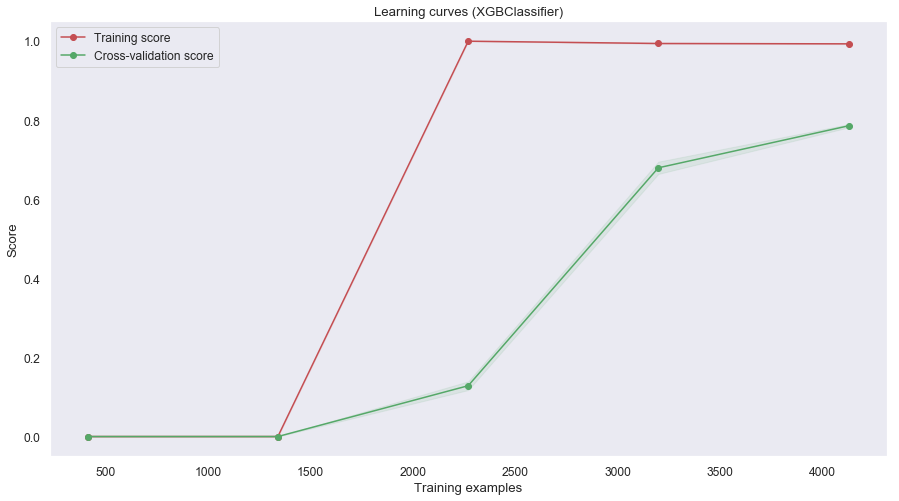

In [63]:
show_learning_curve_plot(model_xgb, X_credit, Y_credit)

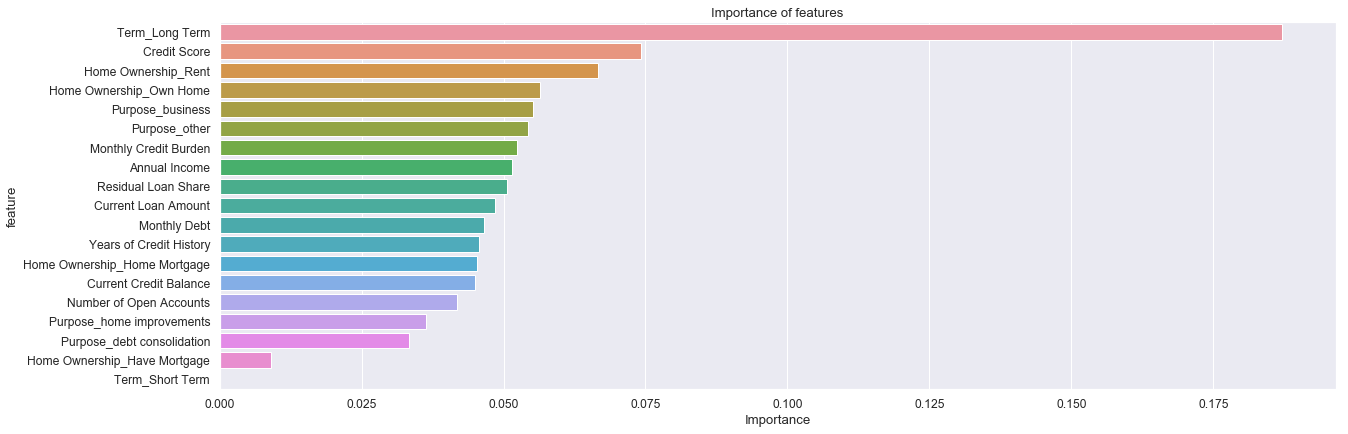

In [64]:
important_features_top = show_feature_importances(X_credit_train_scaled.columns, model_xgb.feature_importances_, get_top=17)

In [65]:
Y_test_pred_probs = model_xgb.predict_proba(X_credit_test_scaled)

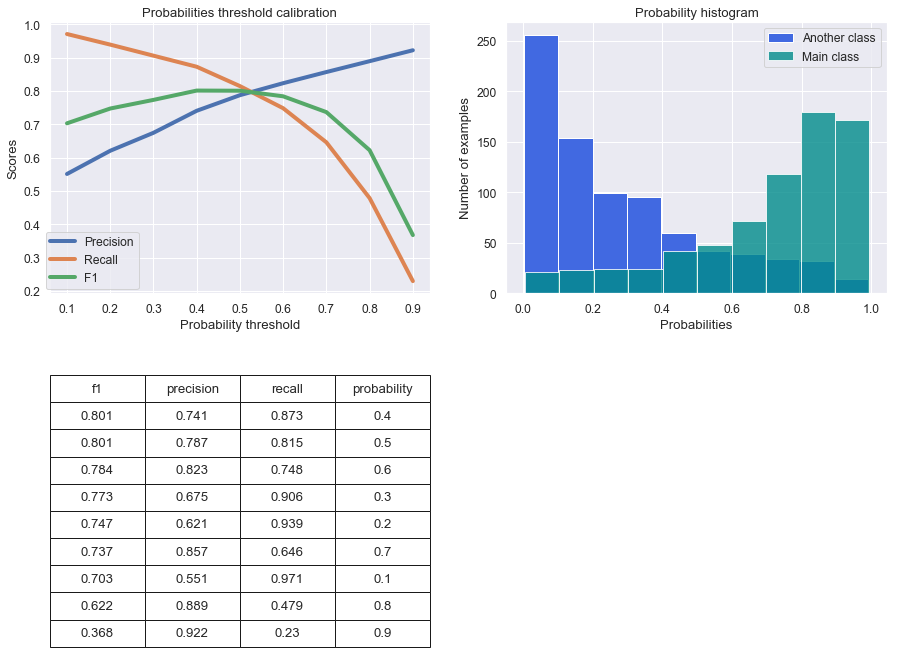

In [66]:
show_proba_calibration_plots(Y_test_pred_probs[:, 1], Y_credit_test)

__Финальная модель.__

In [67]:
scaler_credit_final = MinMaxScaler()
X_credit_scaled = pd.DataFrame(scaler_credit_final.fit_transform(X_credit), columns=X_credit.columns)

model_credit_final = xgb.XGBClassifier(feature_names=cat_columns, random_state=21, nthread=-1)

model_credit_final.fit(X_credit_scaled, Y_credit);

In [68]:
with open('scaler_credit.sc', 'wb') as file:
    pickle.dump(scaler_credit_final, file)

with open('model_credit.ml', 'wb') as file:
    pickle.dump(model_credit_final, file)

# __Прогнозирование на тестовом датасете.__

__Подготовка датасета.__

In [69]:
Test_x_income_empty = df_test_clean[df_test_clean['Annual Income'].isnull()].drop(['Annual Income', 'Credit Score'], 
                                                                                  axis=1).copy()

Test_y_pred_income_boxcox_final = rfr_income_final.predict(Test_x_income_empty)

df_test_full = df_test_clean.copy()

df_test_full.loc[df_test_full['Annual Income'].isnull(), 'Annual Income'] = Test_y_pred_income_boxcox_final
df_test_full.loc[df_test_full['Annual Income'].notnull(), 'Annual Income'] = \
    boxcox(df_test_full.loc[df_test_full['Annual Income'].notnull(), 'Annual Income'], lmbda=lmbda_income)

In [70]:
Test_x_score_empty = df_test_full[df_test_full['Credit Score'].isnull()].drop('Credit Score', axis=1).copy()

Test_y_pred_score_final = rfr_score_final.predict(Test_x_score_empty)

df_test_full.loc[df_test_full['Credit Score'].isnull(), 'Credit Score'] = np.round(Test_y_pred_score_final)

In [71]:
df_test_full = add_parameters(df_test_full, lmbda_income)

__Прогнозирование.__

In [72]:
Test_x_credit_scaled = pd.DataFrame(scaler_credit_final.transform(df_test_full), columns=df_test_full.columns)

Test_y_credit = model_credit_final.predict(Test_x_credit_scaled)

Test_y_credit_proba = model_credit_final.predict_proba(Test_x_credit_scaled)

__Калибровка результатов.__

In [73]:
Test_y_credit_final = Test_y_credit.copy()
Test_y_credit_final[np.where(Test_y_credit_proba[:,1] < 0.55)] = 0

In [74]:
print(f'До калибровки: {Counter(Test_y_credit)}')
print(f'После калибровки: {Counter(Test_y_credit_final)}')

До калибровки: Counter({0: 1441, 1: 1059})
После калибровки: Counter({0: 1560, 1: 940})


__Сохранение результатов.__

In [75]:
pred_credit = pd.DataFrame({'Credit Default':Test_y_credit_final}, columns=['Credit Default'])
pred_credit.to_csv('ABelinsky_predictions.csv', sep=',', index=None, encoding='utf-8')